# Supervised Model Training & Performance Evaluation 


In [1]:
# import libraries
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

### Data Preprocessing for Model Training and Evaluation

In [2]:
# Read the dataset
df = pd.read_csv("modified_dataset.csv")

# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # removing non-word characters
    text = re.sub(r'\W', ' ', str(text))
    # converting letters to lowercase
    text = text.lower()
    # lemmatizing and filtering stop words 
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

# Apply text preprocessing
df['REVIEW_TEXT'] = df['REVIEW_TEXT'].apply(preprocess_text)

# Split the data
X = df.drop('LABEL', axis=1)
y = df['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define lists of feature types for preprocessing steps
numeric_features = ['RATING', 'RATIO_REPEATING_WORDS', 'CAPITALIZATION_COUNT', 
                    'PUNCTUATION_COUNT', 'TEXT_LENGTH', 'SENTIMENT_POLARITY', 
                    'FK_SCORE', 'IMPORTANT_WORDS_COUNT', 'STOPWORDS']
# Numeric preprocessing: Impute missing values with median and scale data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handles missing values
    ('scaler', StandardScaler())                    # Standardizes numeric features
])

# Text feature for transformation
text_features = 'REVIEW_TEXT'
# Text preprocessing: Convert text to a numerical representation
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())  # Converts text to TF-IDF coefficients
])

# Categorical features to be one-hot encoded
categorical_features = [col for col in X.columns if col not in numeric_features + [text_features]]
# Categorical preprocessing: Impute missing values and apply one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fills missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Converts categorical data to one-hot vectors
])

# Combine all preprocessing steps into a single transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),  # Apply numeric transformer to numeric features
    ('cat', categorical_transformer, categorical_features),  # Apply categorical transformer
    ('text', text_transformer, text_features)  # Apply text transformer
])

### Hyperparameter Tuning and Model Development

In [3]:
# Define the scorer
scorer = make_scorer(accuracy_score)

# Models and their hyperparameter grids
model_params = {
    'KNN': (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7]}),
    'SVM': (SVC(random_state=42, probability=True), {'classifier__C': [0.1, 1], 'classifier__kernel': ['rbf', 'linear']}),
    'RF': (RandomForestClassifier(random_state=42), {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [None, 10]}),
    'LR': (LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs'), {'classifier__C': [0.01, 0.1, 1]})
}

# Iterating over models and their parameter grids for tuning
best_models = {}
best_scores = {}

for name, (model, params) in model_params.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Apply GridSearchCV with 5-fold cross-validation 
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring=scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    
    print(f"{name} Best Score: {best_scores[name]:.4f}")
    print(f"{name} Best Parameters: {grid_search.best_params_}")

# Summarizing the best model across all
best_model_name = max(best_scores, key=best_scores.get)
print(f"Overall Best Model: {best_model_name} with CV Accuracy: {best_scores[best_model_name]:.4f}")

KNN Best Score: 0.7637
KNN Best Parameters: {'classifier__n_neighbors': 7}
SVM Best Score: 0.7995
SVM Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
RF Best Score: 0.7952
RF Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
LR Best Score: 0.7894
LR Best Parameters: {'classifier__C': 0.1}
Overall Best Model: SVM with CV Accuracy: 0.7995


###  Performance Evaluation

KNN - Accuracy: 0.7714, Precision: 0.7724, Recall: 0.7714, F1 Score: 0.7714
KNN Confusion Matrix:


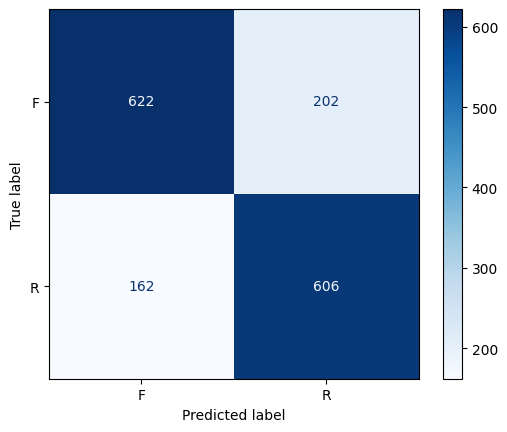

SVM - Accuracy: 0.8216, Precision: 0.8235, Recall: 0.8216, F1 Score: 0.8216
SVM Confusion Matrix:


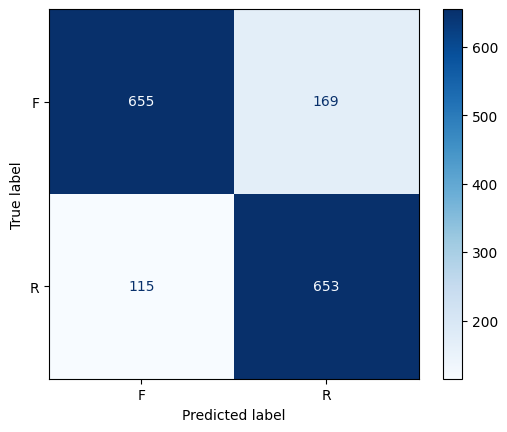

RF - Accuracy: 0.8122, Precision: 0.8122, Recall: 0.8122, F1 Score: 0.8121
RF Confusion Matrix:


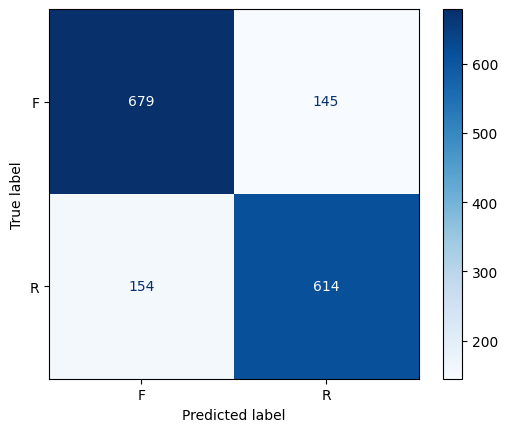

LR - Accuracy: 0.8172, Precision: 0.8179, Recall: 0.8172, F1 Score: 0.8173
LR Confusion Matrix:


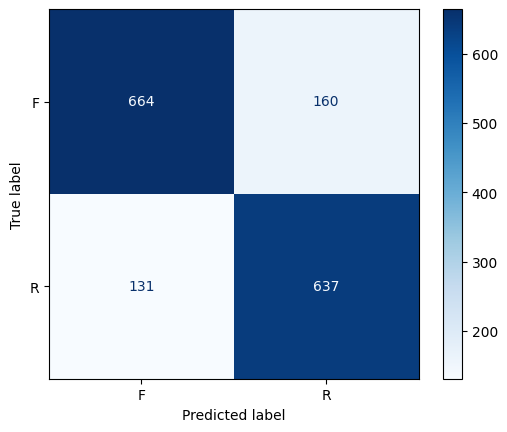

Best Model by F1 Score: SVM with F1 Score: 0.8216


In [11]:
# Initialize a dictionary to store metrics
model_metrics = {}

for name, best_model_pipeline in best_models.items():
    # Make predictions on the test set using the best estimator
    y_pred = best_model_pipeline.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)  

    # Store metrics and the confusion matrix
    model_metrics[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm  # Storing the confusion matrix
    }

# Print all metrics and display confusion matrices
for model, metrics in model_metrics.items():
    print(f"{model} - Accuracy: {metrics['Accuracy']:.4f}, Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, F1 Score: {metrics['F1 Score']:.4f}")

    # Display the confusion matrix
    cm = metrics['Confusion Matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_models[model].classes_)
    print(f"{model} Confusion Matrix:")
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Optionally, to find the best model based on a specific metric
best_by_f1 = max(model_metrics, key=lambda x: model_metrics[x]['F1 Score'])
print(f"Best Model by F1 Score: {best_by_f1} with F1 Score: {model_metrics[best_by_f1]['F1 Score']:.4f}")

### Testing Models with New Data

Model: KNN
Accuracy: 0.7288
Precision: 0.7312
Recall: 0.7288
F1 Score: 0.7280
KNN Confusion Matrix:


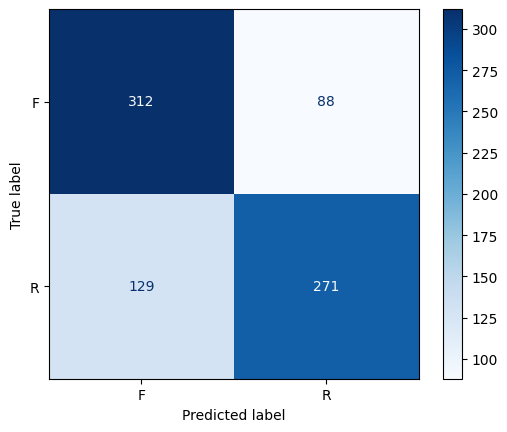

Model: SVM
Accuracy: 0.7725
Precision: 0.7729
Recall: 0.7725
F1 Score: 0.7724
SVM Confusion Matrix:


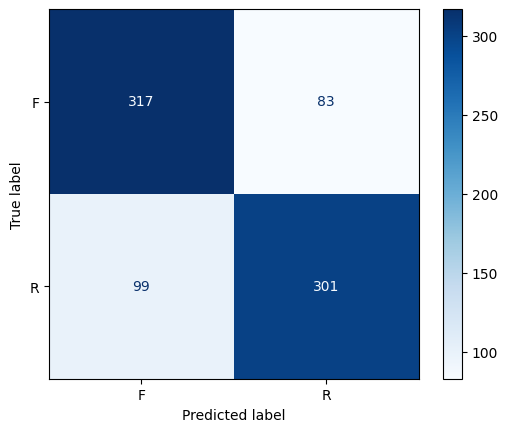

Model: RF
Accuracy: 0.7950
Precision: 0.8060
Recall: 0.7950
F1 Score: 0.7931
RF Confusion Matrix:


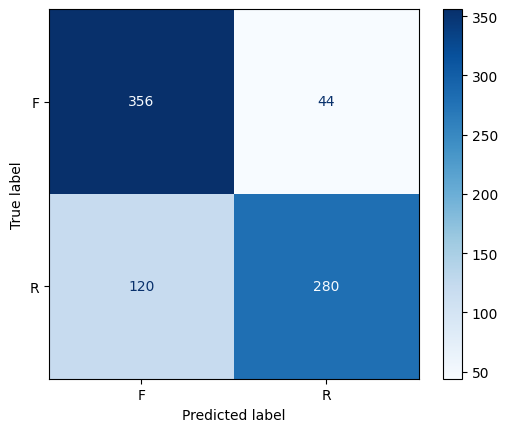

Model: LR
Accuracy: 0.7600
Precision: 0.7632
Recall: 0.7600
F1 Score: 0.7593
LR Confusion Matrix:


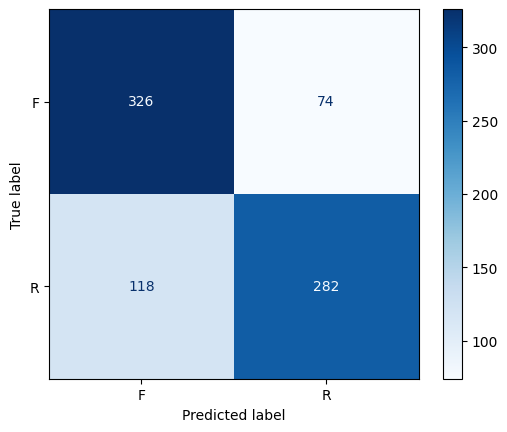

In [14]:
# Load the new dataset
test_df = pd.read_csv("modified_test.csv")

# Set 'Unknown' for missing categorical data
test_df['PRODUCT_NAME_MENTION'] = 'Unknown'

# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

# Apply text preprocessing
test_df['REVIEW_TEXT'] = test_df['REVIEW_TEXT'].apply(preprocess_text)

# Split the data
X_test_new = test_df.drop('LABEL', axis=1)
y_test_new = test_df['LABEL']

# Iterate over all models and evaluate them on the new test dataset
for model_name, model_pipeline in best_models.items():
    # Make predictions on the new test set
    y_pred_new = model_pipeline.predict(X_test_new)

    # Calculate metrics
    accuracy = accuracy_score(y_test_new, y_pred_new)
    precision = precision_score(y_test_new, y_pred_new, average='weighted')
    recall = recall_score(y_test_new, y_pred_new, average='weighted')
    f1 = f1_score(y_test_new, y_pred_new, average='weighted')
    cm = confusion_matrix(y_test_new, y_pred_new)

    # Print metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_pipeline.named_steps['classifier'].classes_)
    print(f"{model_name} Confusion Matrix:")
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

### Retraining Models with Simulated User Feedback

After retraining KNN:
Accuracy: 0.7707, Precision: 0.7717, Recall: 0.7707, F1 Score: 0.7708
KNN Confusion Matrix:


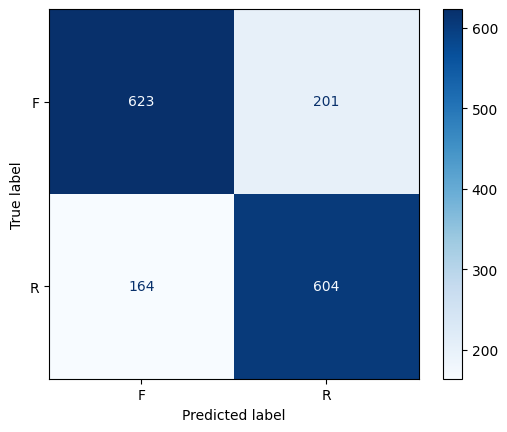

After retraining SVM:
Accuracy: 0.8204, Precision: 0.8219, Recall: 0.8204, F1 Score: 0.8204
SVM Confusion Matrix:


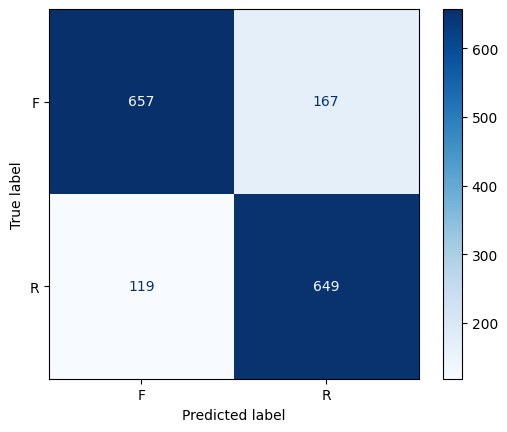

After retraining RF:
Accuracy: 0.8128, Precision: 0.8128, Recall: 0.8128, F1 Score: 0.8127
RF Confusion Matrix:


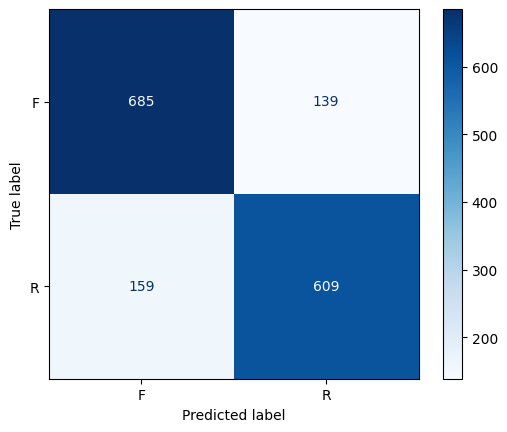

After retraining LR:
Accuracy: 0.8191, Precision: 0.8195, Recall: 0.8191, F1 Score: 0.8191
LR Confusion Matrix:


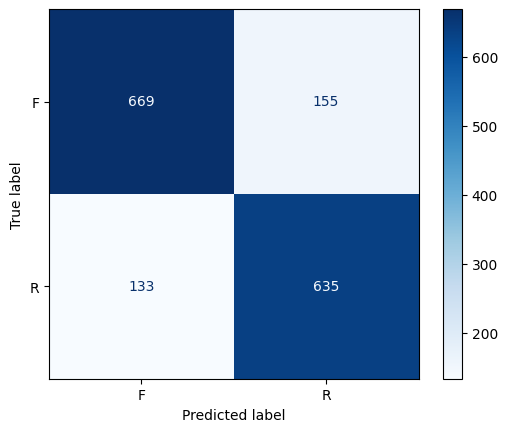

In [6]:
# Load feedback data and preprocess text fields if needed
feedback_df = pd.read_csv("modified_feedback.csv")
feedback_df['REVIEW_TEXT'] = feedback_df['REVIEW_TEXT'].apply(preprocess_text)

# Set 'Unknown' for missing categorical data
feedback_df['PRODUCT_NAME_MENTION'] = 'Unknown'  
feedback_df['VERIFIED_PURCHASE'] = 'Unknown'   

# Separate feedback features and labels
X_feedback = feedback_df.drop('LABEL', axis=1)
y_feedback = feedback_df['LABEL']

# Combine the feedback data with the original training data
X_train_combined = pd.concat([X_train, X_feedback])
y_train_combined = pd.concat([y_train, y_feedback])

# Retrain models with combined data
for name, best_model_pipeline in best_models.items():
    # Fit the model with the combined dataset
    best_model_pipeline.fit(X_train_combined, y_train_combined)
    
    # Predict on the test set
    y_pred = best_model_pipeline.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Calculate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    
    # Output performance metrics
    print(f"After retraining {name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"{name} Confusion Matrix:")
    disp.plot(cmap=plt.cm.Blues)
    plt.show()